## Can Twitter Username Change?

Conclusion is no

In [1]:
from glob import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
all_tweet_file_paths = glob('data/tweets*.json')

In [3]:
username_map = {}
updated_author_id_map = {}

In [4]:
for file_path in tqdm(all_tweet_file_paths):
    
    df = pd.read_json(file_path, dtype=False)
    
    for idx, row in df.iterrows():
        author_id, username = row['author_id'], row['username']

        if username in username_map:
            prev_author_id = username_map[username]

            if author_id != prev_author_id:
                updated_author_id_map[prev_author_id] = author_id
        else:
            username_map[username] = author_id

100%|██████████| 667/667 [01:03<00:00, 10.52it/s]


In [5]:
len(username_map)

37053

In [6]:
len(updated_author_id_map)

0

## Get tweet counts by username

In [7]:
def add_dict_contents(dict1, dict2):
    all_keys = np.unique(list(dict1.keys()) + list(dict2.keys()))
    result = {}
    for k in all_keys:
        result[k] = dict1.get(k, 0) + dict2.get(k, 0)
    return result

In [8]:
tweet_counts_by_username = {}

In [9]:
for file_path in tqdm(all_tweet_file_paths):
    df = pd.read_json(file_path, dtype=False)
    
    temp_count = df.groupby('username').size().to_dict()
    tweet_counts_by_username = add_dict_contents(tweet_counts_by_username, temp_count)

100%|██████████| 667/667 [00:17<00:00, 26.30it/s]


In [10]:
tweet_counts_df = pd.Series(tweet_counts_by_username, name='count').to_frame().reset_index()

In [11]:
tweet_counts_df.columns = ['username', 'count']

In [12]:
tweet_counts_df = tweet_counts_df.sort_values('count', ascending=False)

In [13]:
tweet_counts_df.to_pickle('temp_data/tweet_counts_by_username.pkl')

### Filter by User (with min threhold tweets) + Perform naive sentiment analysis

In [14]:
tweet_counts_df = pd.read_pickle('temp_data/tweet_counts_by_username.pkl')

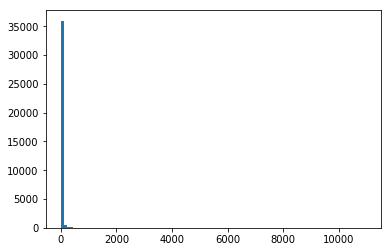

In [15]:
_ = plt.hist(tweet_counts_df['count'], bins=100)

In [16]:
MIN_TWEET_THRESHOLD = 10

In [17]:
tweet_counts_df = tweet_counts_df[tweet_counts_df['count'] >= MIN_TWEET_THRESHOLD]

In [18]:
tweet_counts_df.shape

(6412, 2)

In [19]:
top_usernames = tweet_counts_df['username'].values

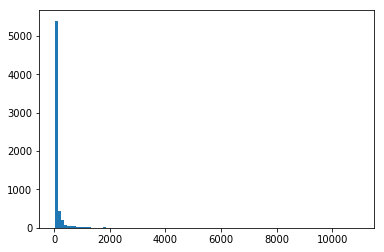

In [20]:
_ = plt.hist(tweet_counts_df['count'], bins=100)

In [21]:
start_date = '2018-01-01'
end_date = '2019-05-13'

In [22]:
dfs = []

In [23]:
for file_path in tqdm(all_tweet_file_paths):
    file_date = file_path.split('_')[1]
    if file_date < start_date:
        continue
    
    df = pd.read_json(file_path, dtype=False)
    df = df[df['username'].isin(top_usernames)].copy()
    dfs.append(df)

100%|██████████| 667/667 [00:05<00:00, 109.34it/s]


In [24]:
top_user_tweets = pd.concat(dfs)

In [25]:
top_user_tweets.head()

,UTC_date,author_id,favorites,geo,hashtags,id,mentions,permalink,replies,retweets,text,to,urls,username
0,"2019-01-25, 23:58",2276424079,1,,,1088949344831721473,,https://twitter.com/EgoEquus/status/1088949344...,2,0,All car companies are the product of some meas...,None,,EgoEquus
1,"2019-01-25, 23:57",1472086890,2,,,1088949052106932225,@http,https://twitter.com/Mexicano_Bulls/status/1088...,0,1,$TSLA the bull pattern is confirmed & a BUY si...,None,http://bit.ly/1y9od8o,Mexicano_Bulls
2,"2019-01-25, 23:47",286547402,8,,,1088946500468563970,,https://twitter.com/TheAdaptedMind/status/1088...,0,0,Koch Bros pay well man. Get in on the cold har...,None,,TheAdaptedMind
3,"2019-01-25, 23:46",50206233,1,,,1088946332906283008,,https://twitter.com/WintonCapPtnrs/status/1088...,0,0,$TSLA $TSLAQhttps://twitter.com/BSA19741/statu...,BSA19741,https://twitter.com/BSA19741/status/1085575365...,WintonCapPtnrs
4,"2019-01-25, 23:45",4549072574,1,,,1088946019595780096,,https://twitter.com/mydoghasagun/status/108894...,1,1,$TSLA Who do you think pays us? https://twitte...,None,https://twitter.com/Michaelsully/status/108894...,mydoghasagun


In [26]:
top_user_tweets.to_pickle('temp_data/top_user_tweets.pkl')

In [27]:
analyser = SentimentIntensityAnalyzer()

def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score['compound']
    #     print("{:-<40} {}".format(sentence, str(score)))

In [28]:
top_user_tweets['sentiment'] = top_user_tweets['text'].apply(sentiment_analyzer_scores)

In [29]:
top_user_tweets.to_pickle('temp_data/top_user_tweets_with_sentiment.pkl')